In [ ]:
pip install pybaseball


     |████████████████████████████████| 419kB 28.8MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 296kB 36.5MB/s 
     |████████████████████████████████| 962kB 35.4MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import random
import math
from pybaseball import playerid_lookup
import urllib
from bs4 import BeautifulSoup
import datetime
import urllib.request 



In [ ]:
from pybaseball import statcast
#download the pitch by pitch data for the 2018 and 2019 seasons
data = statcast(start_dt='2018-03-29', end_dt='2019-09-29')
data.head(2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data.csv', index = False, header=True)


Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data.csv'
data = pd.read_csv(path)


In [ ]:
data.shape #1,463,680 pitches

(1463680, 92)

In [ ]:
#look at all the column names for the dataframe
data.columns
#columns_to_keep = ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z','player_name', 'batter', 'pitcher', 'events', 'description', 'zone', '']

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [ ]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FC,2019-09-29,91.1,-2.16,6.08,"Herrera, Kelvin",641513,516969,strikeout,swinging_strike,NaN,NaN,NaN,NaN,14.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,S,2.0,NaN,2,2,2019,-0.05,0.40,0.08,1.02,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,...,NaN,NaN,NaN,89.9,2347.0,5.8,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.71,NaN,NaN,0.0,1.0,0.0,0.0,NaN,66,5,Cutter,5,3,3,5,3,5,3,5,Standard,Standard,187.0,0.011,-0.099
1,FC,2019-09-29,88.2,-2.22,6.07,"Herrera, Kelvin",641513,516969,NaN,foul,NaN,NaN,NaN,NaN,5.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,S,NaN,NaN,2,1,2019,0.19,0.46,0.16,2.29,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,...,10.0,66.6,-12.0,87.1,2366.0,5.7,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,4,Cutter,5,3,3,5,3,5,3,5,Standard,Standard,158.0,0.000,-0.033
2,FF,2019-09-29,95.8,-1.55,6.41,"Herrera, Kelvin",641513,516969,NaN,ball,NaN,NaN,NaN,NaN,11.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,B,NaN,NaN,1,1,2019,-0.90,1.42,-1.57,2.78,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,...,NaN,NaN,NaN,95.2,2235.0,5.9,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,3,4-Seam Fastball,5,3,3,5,3,5,3,5,Standard,Standard,212.0,0.000,0.024
3,FC,2019-09-29,90.1,-2.16,6.01,"Herrera, Kelvin",641513,516969,NaN,ball,NaN,NaN,NaN,NaN,13.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,B,NaN,NaN,0,1,2019,0.14,0.35,-0.06,0.95,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,...,NaN,NaN,NaN,88.7,2335.0,5.6,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,2,Cutter,5,3,3,5,3,5,3,5,Standard,Standard,159.0,0.000,0.012
4,FF,2019-09-29,98.2,-1.47,6.24,"Herrera, Kelvin",641513,516969,NaN,called_strike,NaN,NaN,NaN,NaN,5.0,Travis Demeritte strikes out swinging.,R,R,R,CWS,DET,S,NaN,NaN,0,0,2019,-0.34,1.17,-0.21,2.78,NaN,NaN,NaN,2,9,Top,NaN,NaN,NaN,...,NaN,NaN,NaN,98.5,2216.0,6.4,567343,516969,641470.0,572365.0,570560.0,660162.0,664901.0,650391.0,641553.0,641477.0,54.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,1,4-Seam Fastball,5,3,3,5,3,5,3,5,Standard,Standard,196.0,0.000,-0.019


Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'babip_value', 'iso_value',
       'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name',
       'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score',
       'post_home_score', 'post_bat_score', 'post_fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis',
       'delta_home_win_exp', 'delta_run_exp'],
      dtype='object')

In [ ]:
#Explore the outcome variable

#find counts for each pitch name 
data['pitch_name'].value_counts()
#remove pitch outs - these arent real pitches
data = data[data.pitch_type != 'PO']

#check for null values
data['pitch_type'].isnull().sum() #10,975 pitches that do not have a pitch type
#need to impute these pitch types in order to preserve the continuity of pitches on a game by game basis

#Impute the pitches that have null values - strategy for this is to impute the pitch type based on that pitcher's individual pitch distribution from the rest of the dataset

#create df of the rows where pitch type is null - will use this to compare to a dictionary created of all pitcher's pitch distributions 
pitch_type_null = data[data['pitch_type'].isna()]
#find counts of pitches for each pitcher
player_pitch_counts = data.groupby(['player_name', 'pitch_type']).size().reset_index(name='counts')
#average of each pitch type for each player - in case need to impute other pitch metrics for a specific pitcher
pitcher_average = data.groupby(['player_name', 'pitch_type']).mean()
pitcher_average = pitcher_average[[ 'release_speed', 'release_spin_rate', 'spin_axis']]
#find total pitches by each pitcher
player_total_pitches = player_pitch_counts.groupby(['player_name']).sum()
#merge the dataframe of counts for each pitch, and total pitches 
player_pitch_dist = pd.merge(player_pitch_counts, player_total_pitches, on='player_name')
#divide counts of each pitch by total number of pitches
player_pitch_dist['percentage'] = player_pitch_dist['counts_x'] / player_pitch_dist['counts_y']
#subset of only the relevant columns
player_pitch_dist = player_pitch_dist[['player_name', 'pitch_type', 'percentage']]
#set the player name as index
player_pitch_dist.set_index("player_name", drop=True, inplace=True)
#make the dataframe into a matrix of players and pitch types (column header), populated by distributions of each pitch for each pitcher
new_player_pitch_dist = player_pitch_dist.pivot(columns = 'pitch_type')
new_player_pitch_dist.columns = new_player_pitch_dist.columns.droplevel(0)
#replace NaN with 0
new_player_pitch_dist= new_player_pitch_dist.fillna(0)
new_player_pitch_dist


In [ ]:
#turn this data frame into a dictionary where the index is the player_names, keys are the pitch types, and the values are the distributions of pitch type for that specific pitcher
pitcher_pitch_distribution = new_player_pitch_dist.to_dict('index')
#make lists of players that are in the pitch_distribution dictionary, and a list of players from the dataframe of null value pitches 
players_from_dictionary = list(pitcher_pitch_distribution.keys())
players_from_df = list(pitch_type_null['player_name'].unique())

#check to see if all players in the dataframe of null values for pitch type are in the dictionary - not actually deleting these players
players_to_delete = []
for player in players_from_df:
  if player not in players_from_dictionary:
    players_to_delete.append(player)
players_to_delete
#Scott Kingery and Kyle Farmer have thrown pitches, but have not thrown any pitches tracked by statcast and therefore have no pitches with which to create a distribution
#to use to impute the null values for their pitch types 
#these players are position players and therefore are not very important in this analysis - can enter FF for their pitches 

#in full dataframe, insert 'FF' as the pitch type for all pitches by Kingery, Scott and Farmer, Kyle
data['pitch_type'] = np.where((data.player_name == 'Kingery, Scott'),'FF',data.pitch_type)
data['pitch_type'] = np.where((data.player_name == 'Farmer, Kyle'),'FF',data.pitch_type)
data.loc[data['player_name'] == 'Kingery, Scott']


In [ ]:
#make lists of players that are in the pitch_distribution dictionary, and a list of players from the dataframe of null value pitches 
players_from_dictionary = list(pitcher_pitch_distribution.keys())
players_from_df = list(pitch_type_null['player_name'].unique())

#check to see if all players in the dataframe of null values for pitch type are in the dictionary
players_to_delete = []
for player in players_from_df:
  if player not in players_from_dictionary:
    players_to_delete.append(player)
players_to_delete
#Scott Kingery and Kyle Farmer have thrown pitches, but have not thrown any pitches tracked by statcast and therefore have no pitches with which to create a distribution
#to use to impute the null values for their pitch types 
#these players are position players and therefore are not very important in this analysis - can enter FF for their pitches 


['Farmer, Kyle', 'Kingery, Scott']

In [ ]:
#in full dataframe, insert 'FF' as the pitch type for all pitches by Kingery, Scott and Farmer, Kyle
data['pitch_type'] = np.where((data.player_name == 'Kingery, Scott'),'FF',data.pitch_type)
data['pitch_type'] = np.where((data.player_name == 'Farmer, Kyle'),'FF',data.pitch_type)
data.loc[data['player_name'] == 'Kingery, Scott']

#now there should be an entry in the pitch distribution dictionary for every player that has a null value in the pitch_type feature

#change NaNs to 0
data['pitch_type']=data.pitch_type.fillna('NaN')

#function for imputing the pitch type for rows that have pitch type equal to NaN
def impute_pitch(pitch, player):
  #if pitch type is NaN
  if pitch == 'NaN':
    #lookup the entry for that player in the dictionary
    x = pitcher_pitch_distribution.get(player)
    #make a random guess for the pitch type (using that pitcher's distributions as the weights for the random guess)
    y = random.choices(population = list(x.keys()), weights = list(x.values()), k = 1 )
    return y[0]
  else:
    return pitch

#apply the function to the full dataframe
data['imputed_pitch'] = data.apply(lambda row: impute_pitch(row['pitch_type'], row['player_name']),axis=1)

In [ ]:
#change NaNs to 0
data['pitch_type']=data.pitch_type.fillna('NaN')


#function for imputing the pitch type for rows that have pitch type equal to NaN
def impute_pitch(pitch, player):
  #if pitch type is NaN
  if pitch == 'NaN':
    #lookup the entry for that player in the dictionary
    x = pitcher_pitch_distribution.get(player)
    #make a random guess for the pitch type (using that pitcher's distributions as the weights for the random guess)
    y = random.choices(population = list(x.keys()), weights = list(x.values()), k = 1 )
    return y[0]
  else:
    return pitch

#apply the function to the full dataframe
data['imputed_pitch'] = data.apply(lambda row: impute_pitch(row['pitch_type'], row['player_name']),axis=1)

#new value counts for all pitches
data['imputed_pitch'].value_counts() #of course, fastballs still dominate
#check to make sure that there are no null values  
data['imputed_type'].isnull().sum()

#show the different pitch types and their overall frequency
data['imputed_pitch'].value_counts()
data.imputed_pitch.value_counts().plot(kind = 'bar') #four seem fastballs look to make up nearly half of the total number of pitches


In [ ]:
#Explore input Features / Feature Engineering

#Release speed

data['release_speed'].isnull().sum() #369 pitches do not have a pitch speed - very tiny fraction of overall data, so just use median speed as strategy to fill na's 
#assign the median pitch speed to these pitches
speed_median = data['release_speed'].median()
data['release_speed'] = data['release_speed'].fillna(value = speed_median)


In [ ]:
#Zone

#check the zone category - this is the zone the pitch is delivered in 
data['zone'].value_counts()
data['zone'].isnull().sum()
#fill na values with 5 = zone in the middle of the strike zone
data['zone'] = data['zone'].fillna(value = 5)


In [ ]:
#Score of game - the score of the game before the pitch is thrown is hypothesized to influence the pitch the pitcher/catcher decide to throw

#create score difference feature
#function to determine score difference for the team that is pitching
def score_diff(inning, home_score, away_score):
  score = 0
  if inning == 'Top':
    score = home_score - away_score
  else:
    score = away_score - home_score
  return score

data['score_difference'] = data.apply(lambda row: score_diff(row['inning_topbot'], row['home_score'], row['away_score']),axis=1)


In [ ]:
#Balls and Strikes

#make a feature for the count at the start of the pitch
#categorical feature - neurtral (neutral count) / batter (count favors the batter) / pitcher (count favors the pitcher)

#9 rows have 5 in the 'balls'column - this is a mistake, should be 3
data["balls"].replace({4: 3}, inplace=True)
#first concatenate the balls and strikes column to make a count column
data['count'] = data['balls'].astype(str) + data['strikes'].astype(str)
data['count'] = data['count'].astype(str)
#define what counts are neutral / advantageous to pitcher or catcher
def define_advantage(count):
  neutral = ['00', '11', '32']
  p_adv = ['01', '12', '22', '02']
  b_adv = ['10', '21', '20', '31', '30']
  if count in neutral:
    return 'neutral'
  if count in p_adv:
    return 'pitcher'
  if count in b_adv:
    return 'batter'
data['advantage'] = data.apply(lambda row: define_advantage(row['count']), axis = 1)

In [ ]:
#feature for if there is any one on base at the end of the pitch

In [ ]:
#Feature for the batter 
#the ability of the batter impacts how the pitcher attacks the hitter - for example, I suspect that, on average, pitchers will throw fewer fastballs to good hitters
#download batter stats from fangraphs from a certain year or range of years

#helper function for getting rows from the table - in fangraphs, the rows are alternating classes rgRow and rgAltRow
def GetRows(table):
    rows = table.find_all('tr', {'class':['rgRow','rgAltRow']})
    return rows

#function for getting the standard team batting data from the start_season until the end_season, and saves it in a dataframe where the last column is the year the data came from
def player_batting_fangraphs(start_season, end_season=None):
    """
    Get season-level Batting Statistics for Specific Team (from Fangraphs)
    ARGUMENTS:
    start_season : int : first season you want data for (or the only season if you do not specify an end_season)
    end_season : int : final season you want data for
    """
    if start_season is None:
        raise ValueError("You need to provide at least one season to collect data for.")
    if end_season is None:
        end_season = start_season
    #define the headings of the columns 
    headings = ["#",'Name',"Team","G","PA","HR","R","RBI","SB","BB%","K%","ISO","BABIP","AVG","OBP","SLG","wOBA","xwOBA","wRC+","BsR","Off","Def",'WAR']
    #create an empty list
    df = pd.DataFrame()
    for season in range(start_season, end_season+1):
      for page in range(1,13):
        #url where the batting table can be found - url format stays the same, only the year changes
        url = """ https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=50&type=8&season={year}&month=0&season1={year}&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate={year}-01-01&enddate={year}-12-31&sort=18,d&page={page}_50""".format(year=season, page = page)
        #send request
        page = urllib.request.urlopen(url)
        #create a beautifulsoup object and pass in the page and lxml parser
        soup = BeautifulSoup(page,'lxml')
        #find the table based on its class attribute, and store table
        table = soup.find('table',class_='rgMasterTable')
        #get the text from the rows - text is defined by td, rows defined by tr
        rows = [[data.get_text() for data in r.select('td')] for r in GetRows(table)]
        #create the data frame
        data = pd.DataFrame(data=rows,columns=headings)
        #add the year on to the end of the dataframe so the team/year combination can be uniquely identified
        data["Year"] = str(season)
        #create the year column on the end of the dataframe so we can identify between rows of the same team
        df = df.append(data)
    return df

In [ ]:
#download the batting stats from fangraphs
hitter_data = player_batting_fangraphs(2019)

In [ ]:
#save to csv in colab notebook folder
#hitter_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/hitter_data.csv', index = False, header=True)

#load hitter data from colab notebook folder
hitter_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hitter_data.csv')

In [ ]:
#keep just the Name and wRC+ columns - wRC+ chosen as a representation of how good the batter is at hitting 
hitters = hitter_data[['Name', 'wRC+']]
hitters['wRC+'] = hitters['wRC+'].astype(int)
hitters.describe()
#define a wRC+ number to assign to hitters who are not found in the fangraphs stats
hitter_impute = 64.00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#split Name into first name and last name,
hitters[['First','Last', 'Middle']] = hitters.Name.str.split(" ",expand=True,)

#need to get id from the statcast database for each player so this can be merged with full dataframe
def get_hitter_id(first_name, last_name):
  #use function from pybaseball - playerid_lookup - inputs are last name, first name of a player in the database, and it give out different IDs
  batter = playerid_lookup(last_name, first_name)
  #error to handle mismatches - sometimes the name is not the same in fangraphs and statcast
  #return 0 if there is no match - these are the names that will have to be investigated to find a match 
  try:
    id = batter.key_mlbam[0]
  except KeyError:
    id = 0
  return id


hitters['batter'] = hitters.apply(lambda row: get_hitter_id(row['First'], row['Last']), axis = 1)
hitters.batter.value_counts()#24 hitters were not matched to an id


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0         24
668670     1
571745     1
664926     1
571740     1
          ..
669374     1
660162     1
527049     1
605508     1
452095     1
Name: batter, Length: 544, dtype: int64

In [ ]:
# names of hitters that dont match
hitters.loc[hitters['batter'] == 0]



In [ ]:
#look up these hitters manually if they are expected to have many plate appearances 
alvarez = playerid_lookup('Álvarez', 'Yordan')
alvarez_id = alvarez.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'Yordan Alvarez'),alvarez_id,hitters.batter)


martinez = playerid_lookup('martinez', 'J. D.', fuzzy = True)
martinez_id = martinez.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'J.D. Martinez'),martinez_id,hitters.batter)


davis = playerid_lookup('Davis', 'J. D.', fuzzy = True)
davis_id = davis.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'J.D. Davis'),davis_id,hitters.batter)


lastella = playerid_lookup('la stella', 'tommy', fuzzy = True)
lastella_id = lastella.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'Tommy La Stella'),lastella_id,hitters.batter)


diaz_A = playerid_lookup('Díaz', 'Aledmys', fuzzy = True)
diaz_A_id = diaz_A.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'Aledmys Diaz'),diaz_A_id,hitters.batter)


diaz_Y = playerid_lookup('Díaz', 'Yandy', fuzzy = True)
diaz_Y_id = diaz_Y.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'Yandy Diaz'),diaz_Y_id,hitters.batter)


abreu = playerid_lookup('Abreu', 'José', fuzzy = True)
abreu_id = abreu.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'Jose Abreu'),abreu_id,hitters.batter)


vogel = playerid_lookup('Vogelbach', 'Dan', fuzzy = True)
vogel_id = vogel.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'Daniel Vogelbach'),vogel_id,hitters.batter)


realmuto = playerid_lookup('Realmuto', 'J. T.', fuzzy = True)
realmuto_id = realmuto.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'J.T. Realmuto'),realmuto_id,hitters.batter)


pollock = playerid_lookup('Pollock', 'AJ', fuzzy = True)
pollock_id = pollock.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'A.J. Pollock'),pollock_id,hitters.batter)

cron = playerid_lookup('Cron', 'C. J.', fuzzy = True)
cron_id = cron.key_mlbam[0]
hitters['batter'] = np.where((hitters.Name == 'C.J. Cron'),cron_id,hitters.batter)

#drop the players with no id match - these players will later get the hitter_impute value for their wRC+ feature
hitters = hitters[hitters.batter != 0]
hitters.batter.value_counts()


In [ ]:
#final dataframe for hitters - just need their id (which is called 'batter'here to match with id column in the full dataframe) and wRC+ 
hitters_final = hitters[['batter', 'wRC+']]
hitters_final.head()

#merge hitters_final with full data on batter - then find any NA's in wRC+ column and replace with hitter_impute number 

,batter,wRC+
0,670541,178
1,545361,178
2,592885,175
3,608324,169
4,112906,163


In [ ]:
pitch_data_full['pitch_type'].value_counts()

def pitch_category(pitch):
  fastballs = ['FF', 'FT', 'FC', 'FA', 'SI']
  breakingballs = ['CU', 'SL', 'SC', 'KC']
  offspeed = ['CH', 'PO', 'FO', 'EP', 'KN', 'FS']
  if pitch in fastballs:
    return 'fastball'
  if pitch in breakingballs:
    return 'breakingball'
  if pitch in offspeed:
    return 'offspeed'
    
pitch_data_full['pitch_category'] = pitch_data_full.apply(lambda row: pitch_category(row['pitch_type']), axis = 1)
pitch_data_full = pitch_data_full.drop(['pitch_type'], axis = 1)

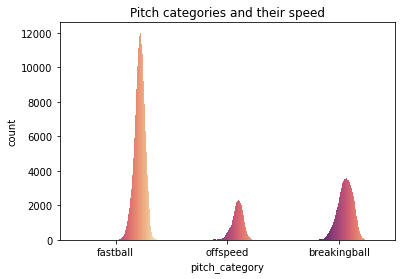

In [ ]:
sns.countplot(x = 'pitch_category', hue = 'release_speed', data = pitch_data_full, palette = 'magma')
plt.legend([],[], frameon=False)
plt.title('Pitch categories and their speed')
plt.show()

In [ ]:
#imbalanced data - more many more fastballs than offpeed pitches or breakingballs
pitch_data_full['pitch_category'].value_counts() 


fastball        866192
breakingball    409460
offspeed        177053
Name: pitch_category, dtype: int64

In [ ]:
#average release_speed, spin rate and spin axis for each pitch category
pitch_data_full.groupby(['pitch_category']).mean()


,release_speed,release_spin_rate,spin_axis
pitch_category,,,
breakingball,82.345714,2450.747016,138.280621
fastball,92.505716,2245.754016,192.560240
offspeed,84.425166,1748.290473,204.699838


In [ ]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
train , test = train_test_split(pitch_data_full, test_size = 0.3)

x_train = train.drop(['pitch_category'], axis=1)
y_train = train[['pitch_category']]

x_test = test.drop(['pitch_category'], axis = 1)
y_test = test[['pitch_category']]

In [ ]:
null_columns=pitch_type_null.columns[pitch_type_null.isnull().any()]
pitch_type_null[null_columns].isnull().sum()

pitch_type               10975
release_speed            10758
release_pos_x            10808
release_pos_z            10808
events                    8227
                         ...  
pitch_name               10975
if_fielding_alignment     7303
of_fielding_alignment     7303
spin_axis                10808
delta_run_exp                3
Length: 61, dtype: int64

In [ ]:

corrMatrix = pitch_data_full.iloc[:, 0:3].corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()